### Import Modules

The cell below imports the required modules to run the following code.

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
import cv2
from skimage.metrics import structural_similarity as ss
from skimage.metrics import peak_signal_noise_ratio as psnr
from scipy.ndimage import sobel
from scipy.linalg import qr
from prettytable import PrettyTable

### Import Images

Two types of images are imported in the cell that follows. The first one is a colorful image that will be used to test the entire pipeline of the image compression described in the report of this project; while the second is a grayscale image on which the customized SVD implementation will be applied. 

The colorful image is a photo of a lightroom, whereas the other one is a BW picture of two skyscrapers and they will be stored in two different formats. The colorful image will have three dimensions: two out of three for the respectively length and width, while the third one is needed to encode each of the three main colors Red, Green and Blue.

In [4]:
col_image = Image.open('lightroom.jpg')
col_image = np.array(col_image).astype(float)

bw_image = Image.open("buildings.jpg")
bw_image =  bw_image.convert("L")
bw_image = np.array(bw_image).astype(float)


print(f"The dimension of the colorful image is {col_image.shape}")
print(f"The dimension of the colorful image is {bw_image.shape}")

The dimension of the colorful image is (956, 640, 3)
The dimension of the colorful image is (512, 512)


### RGB Channels

In order to compress the colorful image, it is needed to extract all the three colors channels separately. The preferred format to store this content is the python dictionary, that allows to access each of the array directly and independently.

In [ ]:
def RGB_channels(image):
    r, g, b = image[:, :, 0], image[:, :, 1], image[:, :, 2]
    return  {'red':r,'green':g,'blue':b}

A visualization of the process may be required at this point. The cell below apply the RGB_channels function to the colorful image and split it into the three submatrices of which is composed. Each of the entrance of the RGB matrices report the shade of that color assigned to that specific pixel in the image, then the mixture of the three reproduces the human visual perception of the full spectrum of colors.

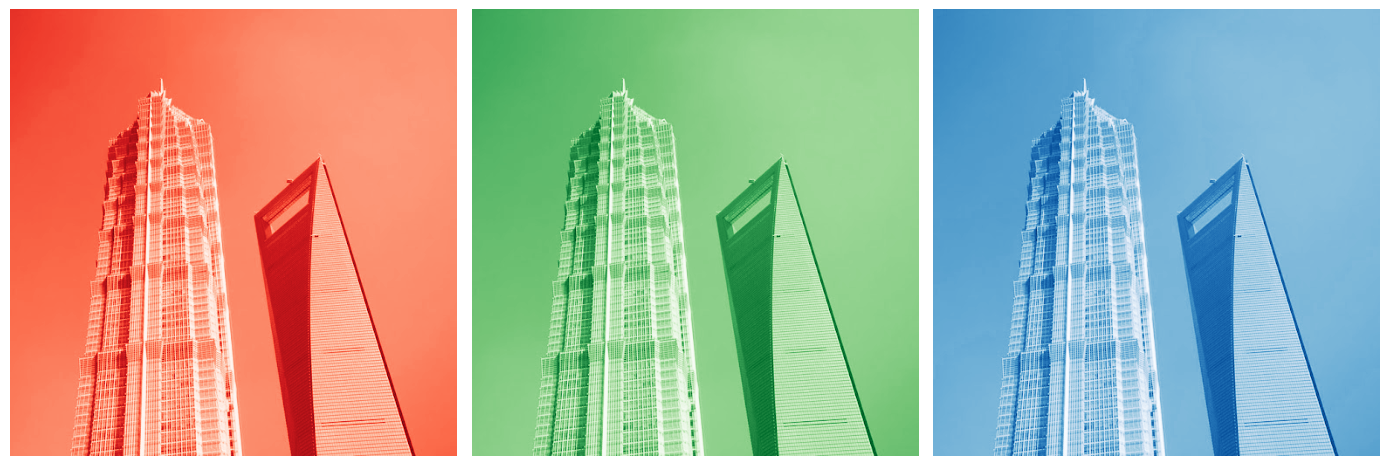

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7))
ax[0].imshow(r, cmap="Reds_r")
ax[0].axis('off')
ax[1].imshow(g, cmap="Greens_r")
ax[1].axis('off')
ax[2].imshow(b, cmap="Blues_r")
ax[2].axis('off')
plt.tight_layout()

In [15]:
import numpy as np

def householder_reflection(a):
    """
    Constructs a Householder reflection matrix that zeroes out all entries below the first element of vector a.
    Returns the Householder matrix H and the vector v used in the reflection.
    """
    v = a.copy()
    v[0] += np.sign(a[0]) * np.linalg.norm(a)
    H = np.eye(len(a)) - 2 * (np.outer(v, v)/np.linalg.norm(v) **2)
    return H, v

def bidiagonalize(A):
    """
    Performs bidiagonalization of matrix A using Householder reflections.
    Returns the bidiagonal matrix B, and the orthogonal matrices P and Q such that A = P * B * Q^T.
    """
    m, n = A.shape
    P = np.eye(m)  
    H = np.eye(n)  
    B = A.copy()  

    for k in range(min(m, n)):
        a = B[k:m, k]
        Hk, v = householder_reflection(a)
        B[k:m, k:n] = Hk @ B[k:m, k:n]
        P[:, k:m] = P[:, k:m] @ Hk.T
        if k < n - 1:
            b = B[k, k+1:n]
            Hk, v = householder_reflection(b)
            B[k:m, k+1:n] = B[k:m, k+1:n] @ Hk.T
            H[k+1:n, :] = Hk @ H[k+1:n, :]
    
    return B, P, H

In [16]:
def SVD(A, comp_sing_vect=True):
    B, P, H = bidiagonalize(A)
    squared_sing_values, Q_tilde = np.linalg.eigh(B.T @ B)
    sing_values = np.sqrt(squared_sing_values)
    sort_idx = np.argsort(sing_values)[::-1]
    sing_values = sing_values[sort_idx]

    Q = H @ Q_tilde
    C = A @ Q

    U, R, pivot_indices = qr(C, pivoting=True)
    sign_adjustment = np.sign(np.diag(R))
    U = U @ np.diag(sign_adjustment)
    Sigma = np.diag(sing_values)
    V = Q @ np.diag(sign_adjustment)
    V = V[:, sort_idx] 

    if not comp_sing_vect:
        return sing_values

    return U, Sigma, V.T

In [17]:
def svd_to_color(color, channel, svd_colors):
    U, S, V = SVD(channel)
    svd_colors[color] = U, S, V
    return svd_colors, S

In [44]:
svd_colors = {}
S_colors = {}       #Colors of the singular value
for color in colors:
    channel = colors[color]
    svd_colors, S = svd_to_color(color, channel, svd_colors)
    S_colors[color] = np.diagonal(S)

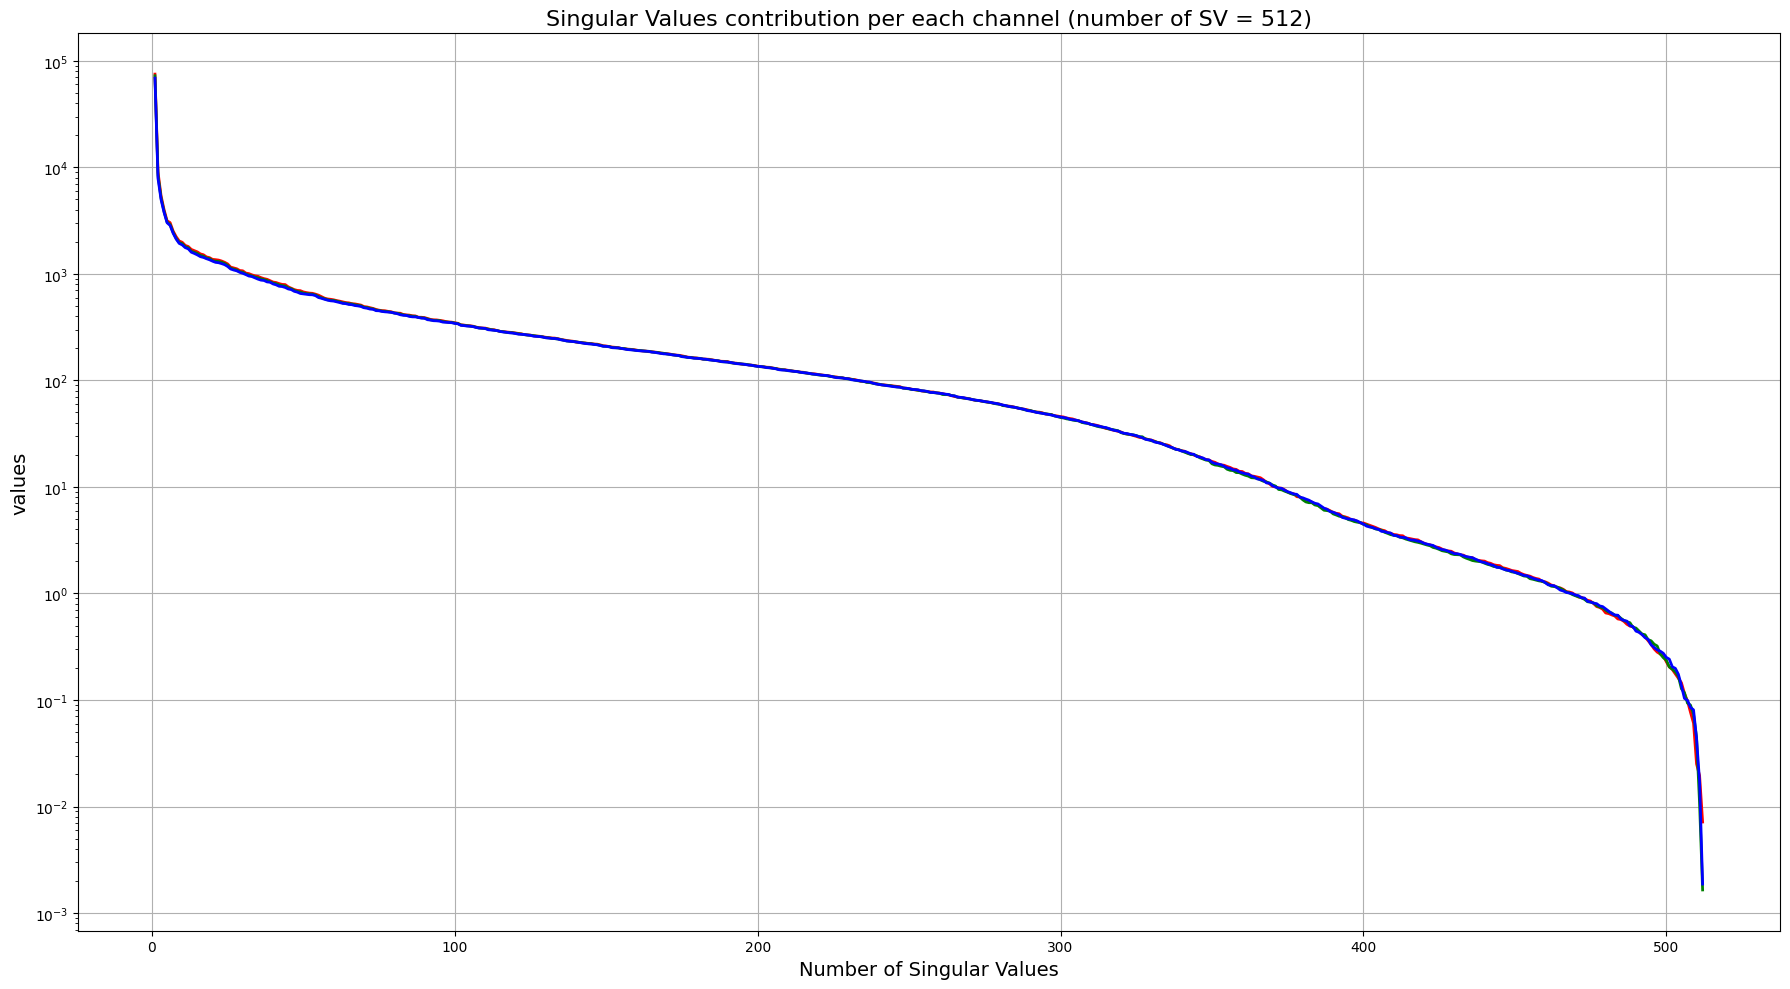

In [45]:
plt.figure(figsize=(18, 10))
for c in S_colors:
    x = np.arange(1, max_s + 1)
    plt.semilogy(x,S_colors[c], c, linewidth=2, label=c)
    plt.grid()
    plt.xlabel('Number of Singular Values', fontsize=14)
    plt.ylabel(f'values', fontsize=14)
    plt.title(f'Singular Values contribution per each channel (number of SV = {max_s})', fontsize=16)
plt.tight_layout()
plt.show()

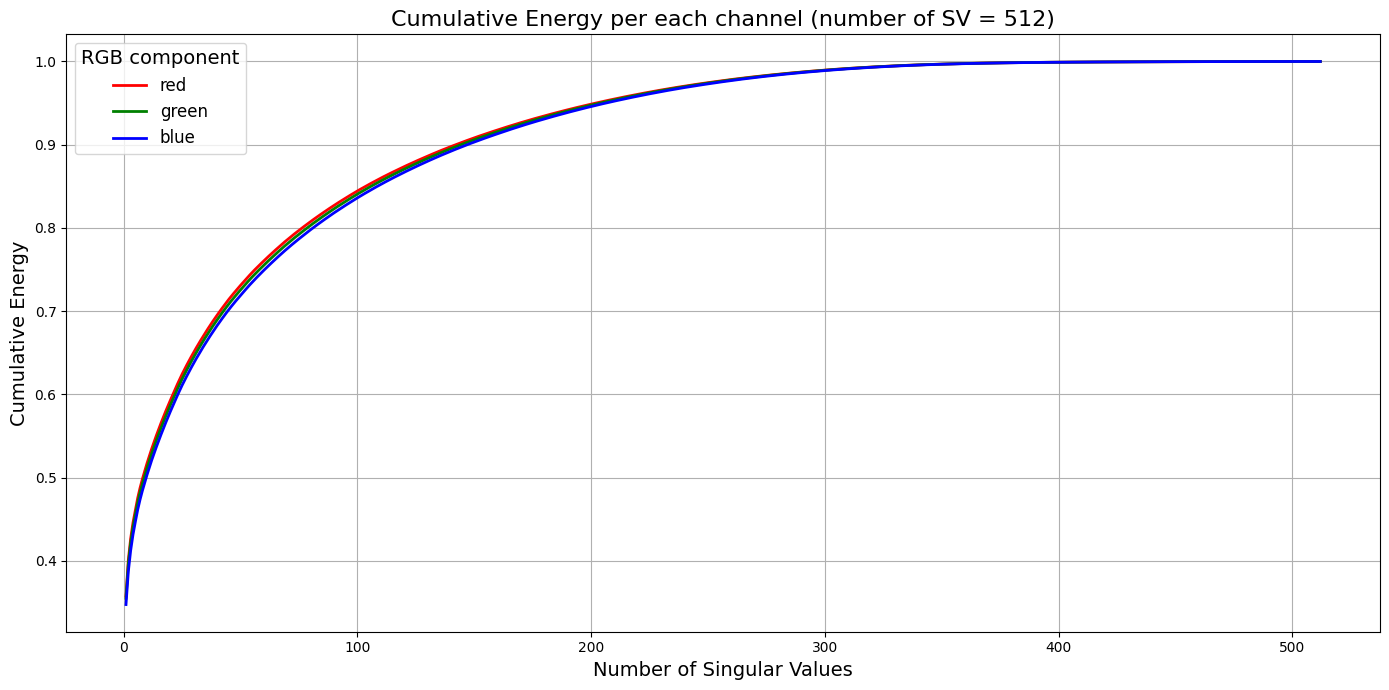

In [46]:
plt.figure(figsize=(14, 7))
for c in S_colors:
    x = np.arange(1, max_s + 1)
    cumulative_energy = np.cumsum(S_colors[c]) / np.sum(S_colors[c])
    plt.plot(x, cumulative_energy, c, linewidth=2, label=c)
    plt.grid()
    plt.xlabel('Number of Singular Values', fontsize=14)
    plt.ylabel('Cumulative Energy', fontsize=14)
    plt.title(f'Cumulative Energy per each channel (number of SV = {max_s})', fontsize=16)
plt.legend(title='RGB component', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

In [59]:
n_singular_values = [10,50,100]
compressed_images = []

for sv in n_singular_values:
    print('\nNumber of singular values:', sv)
    compressed_size = sv * (1 + m + n) * 3
    compressed_colors = []
    S_colors = {}
    for color in svd_colors:
        U, S, V = svd_colors[color]
        U = U[:, :sv]
        S = S[:sv,:sv]
        V = V[:sv, :]
        compressed_color = np.dot(U, np.dot(S, V))
        compressed_color = np.clip(compressed_color, 0, 255).astype('uint8')
        c_compressed= Image.fromarray(compressed_color)
        S_retained = S
        compressed_colors.append(c_compressed)
        S_colors[color] = S_retained

    compressed_image = Image.merge("RGB", compressed_colors)
    compressed_images.append(compressed_image)

    table = PrettyTable()
    table.field_names = ['Original image size', 'Compressed image size','Compression%']
    table.add_row([m*n*3,compressed_size,ratio*100])
    print(table)


Number of singular values: 10
+---------------------+-----------------------+-------------------+
| Original image size | Compressed image size |    Compression%   |
+---------------------+-----------------------+-------------------+
|        786432       |         30750         | 60.89935302734375 |
+---------------------+-----------------------+-------------------+

Number of singular values: 50
+---------------------+-----------------------+-------------------+
| Original image size | Compressed image size |    Compression%   |
+---------------------+-----------------------+-------------------+
|        786432       |         153750        | 60.89935302734375 |
+---------------------+-----------------------+-------------------+

Number of singular values: 100
+---------------------+-----------------------+-------------------+
| Original image size | Compressed image size |    Compression%   |
+---------------------+-----------------------+-------------------+
|        786432       

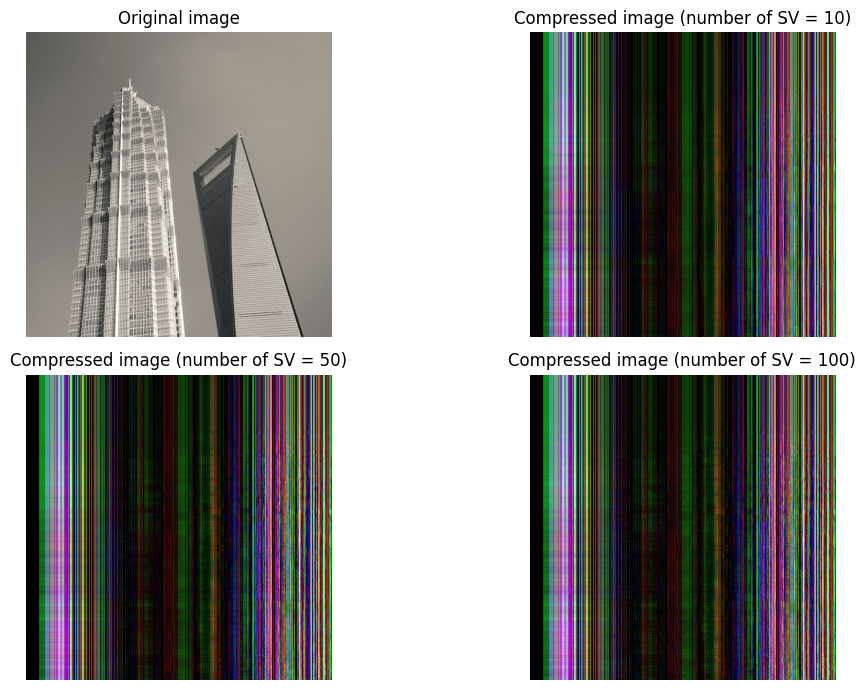

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
ax[0, 0].imshow(image)
ax[0, 0].set_title('Original image')
ax[0, 0].axis('off')
for i, sv in enumerate(n_singular_values):
    compressed_image = compressed_images[i]
    ax[(i+1)//2, (i+1)%2].imshow(compressed_image)
    ax[(i+1)//2, (i+1)%2].set_title(f'Compressed image (number of SV = {sv})')
    ax[(i+1)//2, (i+1)%2].axis('off')
plt.tight_layout()
plt.show()